In [1]:
from PIL import Image
from torchvision import transforms
from src.backbones import Backbone
from src.backbones import ResNetBackbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import torchvision.models as models
from torchvision.models import ResNet101_Weights

models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Test all the individual functionality required for the training pipeline

In [3]:
output_layer_map = {
                "layer1_out": "layer1",
                "layer2_out": "layer2",
                "layer3_out": "layer3",
                "layer4_out": "layer4"
            }

backbone = ResNetBackbone(output_layer_map)

dog_img = Image.open("../data/dog.png")

In [4]:
preprocess = transforms.Compose([
    transforms.Resize((1024, 1024)),      
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

preprocessed_img = preprocess(dog_img).unsqueeze(0)

preprocessed_img.size()

torch.Size([1, 3, 1024, 1024])

In [5]:
features = backbone(preprocessed_img)

In [6]:
features.keys()

dict_keys(['layer1_out', 'layer2_out', 'layer3_out', 'layer4_out'])

In [7]:
print(features['layer1_out'].size()), print(features['layer2_out'].size()), print(features['layer3_out'].size()), print(features['layer4_out'].size())

torch.Size([1, 256, 256, 256])
torch.Size([1, 512, 128, 128])
torch.Size([1, 1024, 64, 64])
torch.Size([1, 2048, 32, 32])


(None, None, None, None)

In [17]:
print(features['conv2'].size()), print(features['conv3'].size()), print(features['conv4'].size()), print(features['conv5'].size())

torch.Size([1, 128, 150, 150])
torch.Size([1, 256, 75, 75])
torch.Size([1, 512, 37, 37])
torch.Size([1, 512, 18, 18])


(None, None, None, None)

In [17]:
fpn = FPN()
fpn_features = fpn(features)
print(fpn_features['conv3'].size()), print(fpn_features['conv4'].size()), print(fpn_features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 256, 37, 37])
torch.Size([1, 256, 18, 18])


(None, None, None)

In [18]:
rpn = RPN()
rpn_out = dict()
for k, v in fpn_features.items():
    rpn_out[k] = rpn(v)

In [19]:
rpn_out['conv3'][0].size(), rpn_out['conv4'][0].size(), rpn_out['conv5'][0].size(), rpn_out['conv3'][1].size(), rpn_out['conv4'][1].size(), rpn_out['conv5'][1].size()

(torch.Size([1, 18, 75, 75]),
 torch.Size([1, 18, 37, 37]),
 torch.Size([1, 18, 18, 18]),
 torch.Size([1, 36, 75, 75]),
 torch.Size([1, 36, 37, 37]),
 torch.Size([1, 36, 18, 18]))

In [21]:
img_shape = (600, 600)
feature_map_key = 'conv4'
rpn_deltas = torch.cat([rpn_out[feature_map_key][1]] * 4, dim=0)
feature_map = fpn_features[feature_map_key]
anchors = generate_anchors()

print(rpn_deltas.size(), feature_map.size(), anchors.shape)
sorted_rpn_keys = sorted(rpn_out.keys())


layer_to_shifted_anchors = dict()
for k in sorted_rpn_keys:
    print(rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))).to(rpn_out[k][1].device).float()

all_rpn_deltas = torch.cat([collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0)
print(all_rpn_deltas.size())
rois = torch.cat([generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape) for k in sorted_rpn_keys], dim=0)
scores = torch.cat([get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0)
# rois = generate_rois(rpn_deltas, anchors, img_shape)
print(rois.size(), scores.size())

rpn_gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 1]
], dtype=torch.float32)
rpn_gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 1]
], dtype=torch.float32)
gt = torch.cat([rpn_gt_batch0, rpn_gt_batch1], dim=0)

rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets, rpn_sampled_indices = matching_and_sampling(rois, scores, gt, 128)
rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]
print(rpn_sampled_proposals.size(), rpn_sampled_scores.size(), rpn_sampled_labels.size(), rpn_sampled_bbox_targets.size(), rpn_sampled_deltas.size())

unique_batches = rois[:, 0].unique()
all_proposals = []
all_scores = []

for batch_idx in unique_batches:
    batch_mask = rois[:, 0] == batch_idx
    batch_rois = rois[batch_mask]
    batch_scores = scores[batch_mask]

    # Perform NMS on the batch
    keep = nms(batch_rois, batch_scores[:, 1])
    batch_rois = batch_rois[keep]
    batch_scores = batch_scores[keep]

    _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
    sorted_proposals = batch_rois[sorted_indices]
    sorted_scores = batch_scores[sorted_indices]

    K = 2000  # for example, adjust K based on your use case
    topk_proposals = sorted_proposals[:K]
    topk_scores = sorted_scores[:K]

    all_proposals.append(topk_proposals)
    all_scores.append(topk_scores)

print(all_proposals[0].size(), all_scores[0].size())
all_proposals = torch.cat(all_proposals, dim=0)
all_scores = torch.cat(all_scores, dim=0)
print(all_proposals.size(), all_scores.size())

all_proposals = all_proposals.detach()
all_scores = all_scores.detach()

gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 2]
], dtype=torch.float32)
gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 2]
], dtype=torch.float32)
gt = torch.cat([gt_batch0, gt_batch1], dim=0)

sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, _ = matching_and_sampling(all_proposals, all_scores, gt, 128)

print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())

pooled_height, pooled_width = 3, 3

levels = sorted([int(x[-1]) for x in rpn_out.keys()])
aligned_proposals = perform_roi_align(levels, sampled_proposals, fpn_features, pooled_height, pooled_width, img_shape)

print(aligned_proposals.size())

torch.Size([4, 36, 37, 37]) torch.Size([1, 256, 37, 37]) (9, 4)
75 75 8
37 37 16
18 18 33
torch.Size([65862, 5])
torch.Size([65862, 5]) torch.Size([65862, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4]) torch.Size([128, 5])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
torch.Size([128, 256, 3, 3])


In [11]:
N, C, H, W = aligned_proposals.size()
num_classes = 4

head = DetectionHead(in_channels=C, pooled_height=H, pooled_width=W, num_classes=num_classes)

cls_scores, bbox_deltas = head(aligned_proposals)

print(cls_scores.size(), bbox_deltas.size())

torch.Size([128, 5]) torch.Size([128, 16])


In [12]:
rpn_cls_loss, rpn_bbox_loss = rpn_loss_fn(rpn_sampled_deltas, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets)
print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())
det_cls_loss, det_bbox_loss = det_loss_fn(bbox_deltas, cls_scores, sampled_labels, sampled_bbox_targets, num_classes)
print(rpn_cls_loss, rpn_bbox_loss, det_cls_loss, det_bbox_loss)

torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
tensor(0.8114, grad_fn=<NllLossBackward0>) tensor(0.4422, grad_fn=<DivBackward0>) tensor(1.5976, grad_fn=<NllLossBackward0>) tensor(0.1619, grad_fn=<DivBackward0>)


Load dataset and experiment

In [1]:
import datasets

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = datasets.load_dataset("detection-datasets/coco")
train_ds = ds['train']
val_ds = ds['val']

mapped_train_ds = train_ds.map(filter_bboxes_in_sample, load_from_cache_file=False)
filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=False)

mapped_val_ds = val_ds.map(filter_bboxes_in_sample, load_from_cache_file=False)
filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=False)

Filter: 100%|██████████| 4952/4952 [00:07<00:00, 643.14 examples/s]


In [6]:
from collections import defaultdict

category_to_count = defaultdict(int)

for sample in tqdm(train_ds):
    if len(sample['objects']['category']) == 0:
        print(sample)
    for obj in sample["objects"]["category"]:
        category_to_count[obj] += 1
category_to_count

100%|██████████| 117266/117266 [07:33<00:00, 258.70it/s]


defaultdict(int,
            {45: 14358,
             50: 7308,
             49: 6399,
             23: 5131,
             58: 8652,
             75: 6613,
             22: 5303,
             25: 11431,
             0: 262465,
             16: 5508,
             17: 6587,
             20: 5513,
             2: 43867,
             7: 9973,
             11: 1983,
             74: 6334,
             6: 4571,
             3: 8725,
             1: 7113,
             36: 5543,
             4: 5135,
             26: 12354,
             43: 7770,
             69: 3334,
             68: 1673,
             73: 24715,
             42: 5479,
             55: 6353,
             13: 9838,
             56: 38491,
             53: 5821,
             60: 15714,
             41: 20650,
             44: 6165,
             59: 4192,
             77: 4793,
             72: 2637,
             71: 5610,
             39: 24342,
             46: 9458,
             48: 4373,
             14: 10806,
            

In [12]:
sorted_category_to_count = dict(sorted(category_to_count.items(), key=lambda x: x[1], reverse=True))
sorted_category_to_count

NameError: name 'category_to_count' is not defined

In [8]:
ds['train'].features['objects'].feature['category'].names

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

In [14]:
transform_pipeline = A.Compose(
    [
        A.Resize(600, 600, cv2.INTER_LANCZOS4),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5)
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"])
)

preprocess = transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

In [9]:
len(filtered_train_ds)

NameError: name 'filtered_train_ds' is not defined

{'image_id': 55585, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x481 at 0x7D54458F3BB0>, 'width': 640, 'height': 481, 'objects': {'bbox_id': [169824, 205822, 213311, 1251828, 1690110, 1695695, 1707847, 1738186, 1741698, 1761461, 2016589, 2151605], 'category': [1], 'bbox': [[111.33, 206.12, 397.77, 343.4]], 'area': [23743.9738]}}
[[111.33, 206.12, 397.77, 343.4]]
(600, 600)
[1]
(600, 600)


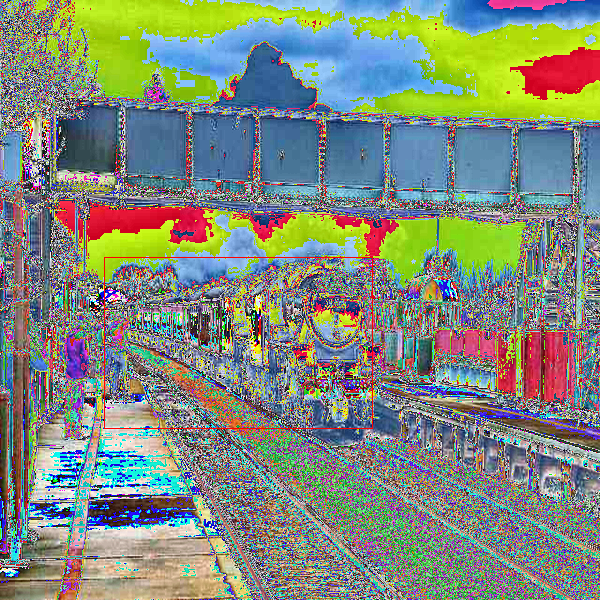

In [22]:
from PIL import ImageDraw

sample = filtered_train_ds[300]
print(sample)
# sample = train_ds[300]

image = np.array(sample["image"])

bboxes = sample['objects']["bbox"]  # list of bounding boxes
labels = sample['objects']["category"]  # list of integer labels

# print(sample['width'], sample['height'])
# print(image.shape)
print(bboxes)
# bboxes = [[bbox[0], bbox[1], bbox[2] + bbox[0] - 1, bbox[3] + bbox[1] - 1] for bbox in bboxes]
transformed = transform_pipeline(image=image, bboxes=bboxes, category=labels)

img = Image.fromarray(transformed["image"]).convert("RGB")
bboxes = transformed["bboxes"]

from torchvision.transforms import ToPILImage
image_tensor = preprocess(img)
to_pil = ToPILImage()
pil_image = to_pil(image_tensor)

print(pil_image.size)

# img = Image.fromarray(image).convert("RGB")
# img = sample['image']
draw = ImageDraw.Draw(pil_image)
for bbox in bboxes:
    draw.rectangle(bbox, outline="red")

print(labels)
print(pil_image.size)
pil_image

In [33]:
sample["image"].size

(340, 736)

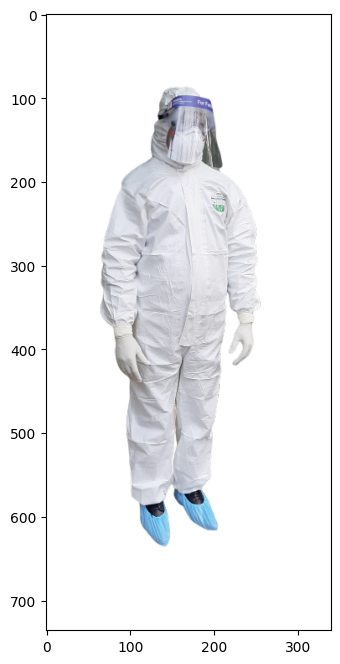

In [28]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)

plt.show()

In [7]:
for el in filtered_train_ds:
    for bbox in el['objects']['bbox']:
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x+w-1, y+h-1
        if (x1 < 0 or x1 >= el['width']) or (x2 < 0 or x2 >= el['width'])  or (y1 < 0 or y1 >= el['height']) or (y2 < 0 or y2 >= el['height']):
            print(bbox, el['width'], el['height'])

# train_ds[0]

In [4]:
ds['train'].features['objects'].feature['category'].names

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

In [5]:
# import torch
# from torchvision.ops import box_convert
# from torchvision.utils import draw_bounding_boxes
# from torchvision.transforms.functional import pil_to_tensor, to_pil_image

# train_ds = ds['train']
# example = train_ds[20]
# categories = train_ds.features['objects'].feature['category']
# boxes_xywh = torch.tensor(example['objects']['bbox'])
# boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
# labels = [categories.int2str(x) for x in example['objects']['category']]
# print(labels)
# to_pil_image(
#     draw_bounding_boxes(
#         pil_to_tensor(example['image']),
#         boxes_xyxy,
#         colors="red",
#         labels=labels,
#     )
# )

Write training pipeline

In [1]:
from PIL import Image
from torchvision import transforms
from src.backbones import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch
import datasets

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
ds = datasets.load_dataset('detection-datasets/coco')
train_ds = ds['train']
val_ds = ds['val']

tgt_categories = [16]
load_from_cache_file = True

mapped_train_ds = train_ds.map(lambda sample: filter_bboxes_in_sample(sample, tgt_categories), load_from_cache_file=load_from_cache_file)
mapped_val_ds = val_ds.map(lambda sample: filter_bboxes_in_sample(sample, tgt_categories), load_from_cache_file=load_from_cache_file)

train_positive_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=load_from_cache_file)
train_negative_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) == 0, load_from_cache_file=load_from_cache_file)

neg_samples = min(len(train_positive_ds), len(train_negative_ds))
train_negative_ds_balanced = train_negative_ds.shuffle(seed=42).select(range(neg_samples))

filtered_train_ds = datasets.concatenate_datasets([train_positive_ds, train_negative_ds_balanced]).shuffle(seed=42)

val_positive_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=load_from_cache_file)
val_negative_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) == 0, load_from_cache_file=load_from_cache_file)

neg_samples = min(len(val_positive_ds), len(val_negative_ds))
val_negative_ds_balanced = val_negative_ds.shuffle(seed=42).select(range(neg_samples))

filtered_val_ds = datasets.concatenate_datasets([val_positive_ds, val_negative_ds_balanced]).shuffle(seed=42)

In [3]:
# Count categories for determining num_classes
category_to_count = defaultdict(int)
for sample in filtered_train_ds:
    for obj in sample["objects"]["category"]:
        category_to_count[obj] += 1

print(category_to_count)

len(filtered_train_ds)

defaultdict(<class 'int'>, {1: 4893})


7842

In [4]:
config = load_config('/home/ubuntu/rishabh/faster-rcnn/src/configs/config_resnet101.yaml')
preprocess_transform = setup_preprocess_transform(config)
augmentation_transform_train = setup_augmentation_transform(config, mode='train')
augmentation_transform_test = setup_augmentation_transform(config, mode='test')

train_dataset = DetectionDataset(filtered_train_ds, augmentation_transform_train, preprocess_transform)
val_dataset = DetectionDataset(filtered_val_ds, augmentation_transform_test, preprocess_transform)

In [7]:
train_dataset[0][1]

{'boxes': tensor([], size=(0, 4)),
 'labels': tensor([], dtype=torch.int64),
 'boxes_with_label': tensor([], size=(0, 5))}

In [9]:
new_targets = add_batch_idx_to_targets([train_dataset[0][1]])
new_targets

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'boxes_with_label': tensor([], size=(0, 6))}]

In [2]:
ds = datasets.load_dataset("detection-datasets/coco")
train_ds = ds['train']
val_ds = ds['val']

mapped_train_ds = train_ds.map(filter_bboxes_in_sample)
filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

# mapped_val_ds = val_ds.map(filter_bboxes_in_sample)
# filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

In [ ]:
mapped_train_ds = train_ds.map(filter_bboxes_in_sample, load_from_cache_file=False)
filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=False)

# mapped_val_ds = val_ds.map(filter_bboxes_in_sample, load_from_cache_file=False)
# filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0, load_from_cache_file=False)

Map:  99%|█████████▉| 994/1000 [00:06<00:00, 142.99 examples/s]

In [3]:
import torch.optim as optim

output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

layer_size_map = {
    'conv3': (75, 75),
    'conv4': (37, 37),
    'conv5': (18, 18)
}

C = 256
pooled_height, pooled_width = 7, 7
anchor_box_ratios=[0.25, 0.5, 1, 2]
anchor_box_scales=[8, 16, 32]
num_anchors = len(anchor_box_ratios) * len(anchor_box_scales)
num_classes = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ckpt = torch.load("/home/ubuntu/rishabh/faster-rcnn/src/checkpoints/model_epoch_3.pth")

backbone = Backbone(output_layer_map).to(device)
# backbone.load_state_dict(ckpt['backbone_state_dict'])
fpn = FPN().to(device)
# fpn.load_state_dict(ckpt['fpn_state_dict'])
rpn = RPN(num_anchors=num_anchors).to(device)
# rpn.load_state_dict(ckpt['rpn_state_dict'])
head = DetectionHead(in_channels=C, pooled_height=pooled_height, pooled_width=pooled_width, num_classes=num_classes).to(device)
# head.load_state_dict(ckpt['head_state_dict'])

optimizer = optim.Adam(
    list(backbone.parameters()) +
    list(fpn.parameters()) +
    list(rpn.parameters()) +
    list(head.parameters()),
    lr=1e-4
)

conv3 16
conv4 23
conv5 30


In [4]:
def train_loop(num_epochs, dataloader, backbone, fpn, rpn, head, optimizer, device,
               layer_to_shifted_anchors, img_shape, num_classes, pooled_height, pooled_width, train_logger):
    """
    Unified training loop for the entire detection network using a single optimizer,
    with logging of metrics to a file.
    
    Args:
        num_epochs (int): Number of epochs.
        dataloader (DataLoader): Training data loader.
        backbone (nn.Module): Backbone network.
        fpn (nn.Module): Feature Pyramid Network.
        rpn (nn.Module): Region Proposal Network.
        head (nn.Module): Detection head.
        optimizer (Optimizer): Single optimizer for all parameters.
        device (torch.device): The computation device.
        layer_to_shifted_anchors (dict): Precomputed shifted anchors per FPN level.
        img_shape (tuple): The input image dimensions.
        num_classes (int): Number of object classes.
    """
    backbone.train()
    fpn.train()
    rpn.train()
    head.train()

    counter = 0

    for epoch in range(num_epochs):
        for i, (images, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Move images and targets to the device
            images = images.to(device)
            targets = add_batch_idx_to_targets(targets)
            gt = torch.cat([t['boxes_with_label'] for t in targets], dim=0).to(device)
            rpn_gt = gt.clone()
            # Convert labels to binary for the RPN (foreground vs background)
            rpn_gt[:, 5] = (rpn_gt[:, 5] > 0).long()

            # Forward pass: Backbone -> FPN.
            features = backbone(images)
            fpn_features = fpn(features)

            # Forward pass through the RPN at each FPN level.
            rpn_out = {}
            for k, feature_map in fpn_features.items():
                rpn_out[k] = rpn(feature_map)
            sorted_rpn_keys = sorted(rpn_out.keys())

            # Aggregate RPN outputs.
            all_rpn_deltas = torch.cat(
                [collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0
            )
            rois = torch.cat(
                [generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape)
                 for k in sorted_rpn_keys], dim=0
            )
            scores = torch.cat(
                [get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0
            )

            print('Matching and Sampling for RPN...')
            # Matching and sampling for RPN training.
            (rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels,
             rpn_sampled_bbox_targets, rpn_sampled_indices) = matching_and_sampling(
                 rois, scores, rpn_gt, 128
             )
            rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]

            # Process proposals for the detection head.
            unique_batches = rois[:, 0].unique()
            all_proposals = []
            all_scores = []
            for batch_idx in unique_batches:
                batch_mask = rois[:, 0] == batch_idx
                batch_rois = rois[batch_mask]
                batch_scores = scores[batch_mask]

                # Apply Non-Maximum Suppression (NMS) per batch.
                keep = nms(batch_rois, batch_scores[:, 1])
                batch_rois = batch_rois[keep]
                batch_scores = batch_scores[keep]

                # Sort proposals by score.
                _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
                sorted_proposals = batch_rois[sorted_indices]
                sorted_scores = batch_scores[sorted_indices]

                K = 2000  # Adjust K based on your requirements.
                topk_proposals = sorted_proposals[:K]
                topk_scores = sorted_scores[:K]

                all_proposals.append(topk_proposals)
                all_scores.append(topk_scores)

            all_proposals = torch.cat(all_proposals, dim=0).detach()
            all_scores = torch.cat(all_scores, dim=0).detach()

            print('Matching and Sampling for Detection...')
            # Matching and sampling for the detection head.
            (sampled_proposals, sampled_scores, sampled_labels,
             sampled_bbox_targets, _) = matching_and_sampling(
                 all_proposals, all_scores, gt, 128
             )

            # ROI Align: pool features corresponding to the proposals.
            levels = sorted([int(x[-1]) for x in rpn_out.keys()])
            aligned_proposals = perform_roi_align(
                levels, sampled_proposals, fpn_features,
                pooled_height, pooled_width, img_shape
            )

            # Forward pass through the detection head.
            cls_scores, bbox_deltas = head(aligned_proposals)

            # Compute losses.
            rpn_cls_loss, rpn_bbox_loss = rpn_loss_fn(
                rpn_sampled_deltas, rpn_sampled_scores,
                rpn_sampled_labels, rpn_sampled_bbox_targets
            )
            det_cls_loss, det_bbox_loss = det_loss_fn(
                bbox_deltas, cls_scores,
                sampled_labels, sampled_bbox_targets, num_classes
            )
            total_loss = rpn_cls_loss + rpn_bbox_loss + det_cls_loss + det_bbox_loss

            # Backpropagation and parameter update.
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Build log message
            log_message = (
                f"Epoch: {epoch+1}, Iteration: {i+1}, Total Loss: {total_loss.item():.4f}, "
                f"RPN_cls: {rpn_cls_loss.item():.4f}, RPN_bbox: {rpn_bbox_loss.item():.4f}, "
                f"DET_cls: {det_cls_loss.item():.4f}, DET_bbox: {det_bbox_loss.item():.4f}"
            )
            # Log to file
            train_logger.info(log_message)

            if counter > 20:
                break

            counter += 1

In [5]:
def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    
    Parameters:
        anchor (ndarray): A 4-element array (x1, y1, x2, y2).
        
    Returns:
        w, h, x_ctr, y_ctr: width, height, x center, and y center of the anchor.
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given vectors of widths (ws) and heights (hs) around a center (x_ctr, y_ctr),
    output a set of anchors (windows).
    
    Parameters:
        ws (ndarray): widths, shape (N,)
        hs (ndarray): heights, shape (N,)
        x_ctr (float): x center
        y_ctr (float): y center
        
    Returns:
        anchors (ndarray): Array of shape (N, 4)
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((
        x_ctr - 0.5 * (ws - 1),
        y_ctr - 0.5 * (hs - 1),
        x_ctr + 0.5 * (ws - 1),
        y_ctr + 0.5 * (hs - 1)
    ))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    
    Parameters:
        anchor (ndarray): Base anchor (4,)
        ratios (list): List of aspect ratios
        
    Returns:
        anchors (ndarray): Array of shape (len(ratios), 4)
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / np.array(ratios)
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * np.array(ratios))
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    
    Parameters:
        anchor (ndarray): Anchor (4,)
        scales (list): List of scales
        
    Returns:
        anchors (ndarray): Array of shape (len(scales), 4)
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * np.array(scales)
    hs = h * np.array(scales)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def matching_and_sampling(all_proposals, all_scores, gt, num_samples):
    sampled_proposals_list = []
    batch_scores_list = []
    sampled_labels_list = []
    sampled_bbox_targets_list = []
    sampled_indices_list = []

    batch_ids = all_proposals[:, 0].unique()

    pos_iou_thresh = 0.5
    neg_iou_thresh = 0.1
    pos_fraction = 0.25

    for batch_idx in batch_ids:
        batch_mask = all_proposals[:, 0] == batch_idx

        global_indices = torch.nonzero(batch_mask).squeeze(1)
        batch_proposals = all_proposals[batch_mask][:, 1:]
        batch_scores = all_scores[batch_mask]

        gt_mask = gt[:, 0] == batch_idx
        gt_b = gt[gt_mask][:, 1:5]
        gt_labels = gt[gt_mask][:, 5].long()

        N_b = batch_proposals.shape[0]
        M_b = gt_b.shape[0]

        # print(batch_proposals.size(), gt_b.size())
        
        # max_ious = torch.zeros(N_b, device=all_proposals.device)
        # gt_assignment = torch.full((N_b,), -1, dtype=torch.long, device=all_proposals.device)
        # for i in range(N_b):
        #     ious = compute_iou(batch_proposals[i], gt_b)  # shape [M_b]
        #     max_iou, idx = ious.max(0)
        #     max_ious[i] = max_iou
        #     gt_assignment[i] = idx
        ious = compute_iou_vectorized(batch_proposals, gt_b)  # [N_b, M_b]
        # print(ious.size())
        max_ious, gt_assignment = ious.max(dim=1)  # max_ious: [N_b], gt_assignment: [N_b]

        # Initialize labels for proposals (default background: label 0).
        labels_b = torch.zeros(N_b, dtype=torch.long, device=all_proposals.device)
        # Regression targets are zeros by default.
        bbox_targets_b = torch.zeros((N_b, 4), device=all_proposals.device)

        pos_inds = max_ious >= pos_iou_thresh
        if pos_inds.sum() > 0:
            labels_b[pos_inds] = gt_labels[gt_assignment[pos_inds]]
            pos_proposals = batch_proposals[pos_inds]
            matched_gt = gt_b[gt_assignment[pos_inds]]
            bbox_targets_b[pos_inds] = bbox_transform(pos_proposals, matched_gt)
        
        # print(bbox_targets_b.size(), labels_b.size())
        valid_inds = (max_ious >= pos_iou_thresh) | (max_ious < neg_iou_thresh)

        num_pos = int(pos_fraction * num_samples)
        pos_idx = torch.nonzero(pos_inds).squeeze(1)
        neg_idx = torch.nonzero((~pos_inds) & valid_inds).squeeze(1)

        num_pos_sample = min(num_pos, pos_idx.numel())
        num_neg_sample = num_samples - num_pos_sample
        print('==========')
        print(batch_proposals.size(), pos_idx.size(), num_pos_sample, num_neg_sample, neg_idx.size(), gt_b.size())
        print('==========')

        if pos_idx.numel() > 0:
            perm_pos = pos_idx[torch.randperm(pos_idx.numel())][:num_pos_sample]
        else:
            perm_pos = pos_idx
        if neg_idx.numel() > 0:
            perm_neg = neg_idx[torch.randperm(neg_idx.numel())][:num_neg_sample]
        else:
            perm_neg = neg_idx
        
        keep_inds = torch.cat([perm_pos, perm_neg], dim=0)
        
        sampled_batch_indices = global_indices[keep_inds]
        sampled_indices_list.append(sampled_batch_indices)

        proposals_keep = batch_proposals[keep_inds]  # shape [K_b, 4]
        batch_scores_keep = batch_scores[keep_inds]  # shape [K_b]
        labels_keep = labels_b[keep_inds]         # shape [K_b]
        bbox_targets_keep = bbox_targets_b[keep_inds]  # shape [K_b, 4]
        
        batch_idx_tensor = torch.full((proposals_keep.shape[0], 1), batch_idx.item(), device=all_proposals.device)
        proposals_keep = torch.cat([batch_idx_tensor, proposals_keep], dim=1)  # now [K_b, 5]

        sampled_proposals_list.append(proposals_keep)
        batch_scores_list.append(batch_scores_keep)
        sampled_labels_list.append(labels_keep)
        sampled_bbox_targets_list.append(bbox_targets_keep)

    # Concatenate results from all batches.
    sampled_proposals = torch.cat(sampled_proposals_list, dim=0)
    sampled_scores = torch.cat(batch_scores_list, dim=0)
    sampled_labels = torch.cat(sampled_labels_list, dim=0)
    sampled_bbox_targets = torch.cat(sampled_bbox_targets_list, dim=0)
    sampled_indices = torch.cat(sampled_indices_list, dim=0)

    return sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, sampled_indices

def generate_anchors(base_size=16, ratios=[0.25, 0.5, 1, 2, 4], scales=[2, 4, 8, 16]):
    """
    Generate base anchors by enumerating aspect ratios and scales.
    
    Parameters:
        base_size (int): The size of the base anchor (typically the stride of the feature map).
        ratios (list): Aspect ratios (height/width) to enumerate.
        scales (list): Anchor scales (multiplicative factors).
        
    Returns:
        anchors (ndarray): Array of shape (N, 4), where N = len(ratios) * len(scales).
                           Each row is (x1, y1, x2, y2).
    """
    # Create a base anchor centered at (0, 0)
    base_anchor = np.array([0, 0, base_size - 1, base_size - 1])
    
    # Enumerate anchors for each aspect ratio
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    
    # For each ratio anchor, enumerate anchors for each scale
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    
    return anchors

def generate_rois(rpn_deltas, shifted_anchors, im_shape):
    """
    Generate candidate RoIs by applying predicted bounding-box deltas to the anchors.
    
    Parameters:
        feature_map (Tensor): Feature map from the backbone network.
        rpn_deltas (Tensor): Predicted bounding-box deltas from the RPN.
        anchors (Tensor): Anchor boxes in [x1, y1, x2, y2] format.
        im_shape (tuple): Shape of the input image (H x W).
        
    Returns:
        rois (Tensor): Region of interests (RoIs) in [x1, y1, x2, y2] format.
    """
    im_h, im_w = im_shape
    B, C, H, W = rpn_deltas.shape

    num_anchors = C // 4

    print(num_anchors)

    rpn_deltas = rpn_deltas.view(B, num_anchors, 4, H, W)

    rpn_deltas = rpn_deltas.permute(0, 3, 4, 1, 2).contiguous().view(B, -1, 4)
    # anchors = shift(anchors, H, W, im_h // H)

    # anchors = torch.from_numpy(anchors).to(rpn_deltas.device).float()

    print(shifted_anchors.size(), rpn_deltas.size(), im_h, im_w)

    rois = torch.stack([decode_boxes(shifted_anchors, rpn_deltas[i], (im_h, im_w)) for i in range(B)], dim=0)

    batch_indices = torch.arange(B, dtype=rois.dtype, device=rois.device).view(B, 1)

    batch_indices = batch_indices.expand(B, rois.size(1)).unsqueeze(2)

    rois = torch.cat([batch_indices, rois], dim=2).view(-1, 5)

    return rois

In [6]:
train_dataset = DetectionDataset(filtered_train_ds, transform_pipeline, preprocess)

In [14]:
img_shape = (600, 600)
anchors = generate_anchors(ratios=anchor_box_ratios, scales=anchor_box_scales)

layer_to_shifted_anchors = dict()
for k in layer_size_map.keys():
    layer_h, layer_w = layer_size_map[k]
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), layer_h, layer_w, img_shape[0] // layer_h)).to(device).float()

print('Shifted Areas' + ('=' * 10))
for k, v in layer_to_shifted_anchors.items():
    areas = (v[:, 2] - v[:, 0] + 1) * (v[:, 3] - v[:, 1] + 1)
    average_area = areas.mean()
    min_area = areas.min()
    max_area = areas.max()
    print(f"{k}: Average Area: {average_area:.2f}, Min Area: {min_area:.2f}, Max Area: {max_area:.2f}")
print('Shifted Areas' + ('=' * 10))

print(anchors.size, layer_to_shifted_anchors['conv3'].size(), layer_to_shifted_anchors['conv4'].size(), layer_to_shifted_anchors['conv5'].size())

idx = 10
images, targets = train_dataset[idx]
images = images.unsqueeze(0)
print(type(images), type(targets))
images = images.to(device)
targets = add_batch_idx_to_targets([targets])
gt = torch.cat([t['boxes_with_label'] for t in targets], dim=0).to(device)
rpn_gt = gt.clone()
rpn_gt[:, 5] = 1

print(images.size(), gt.size())

print('GT Areas' + ('=' * 10))
print(gt)
areas = (gt[:, 3] - gt[:, 1] + 1) * (gt[:, 4] - gt[:, 2] + 1)
average_area = areas.mean()
min_area = areas.min()
max_area = areas.max()
print(f"Average Area: {average_area:.2f}, Min Area: {min_area:.2f}, Max Area: {max_area:.2f}")
print('GT Areas' + ('=' * 10))

features = backbone(images)
fpn_features = fpn(features)

for k in features.keys():
    print(k, features[k].size(), fpn_features[k].size())

rpn_out = {}
for k, feature_map in fpn_features.items():
    rpn_out[k] = rpn(feature_map)
sorted_rpn_keys = sorted(rpn_out.keys())

print(sorted_rpn_keys)

all_rpn_deltas = torch.cat(
    [collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0
)
rois = torch.cat(
    [generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape)
        for k in sorted_rpn_keys], dim=0
)
scores = torch.cat(
    [get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0
)

print(rois.size(), rpn_gt.size())

(rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels,
    rpn_sampled_bbox_targets, rpn_sampled_indices) = matching_and_sampling(
        rois, scores, rpn_gt, 128
    )

print('RPN' + '='*10)
print(rpn_sampled_scores.size(), rpn_sampled_labels.size())
print('RPN' + '='*10)

rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]
# Process proposals for the detection head.
unique_batches = rois[:, 0].unique()
all_proposals = []
all_scores = []
print('Starting Proposal Selection for detection head...')
for batch_idx in unique_batches:
    batch_mask = rois[:, 0] == batch_idx
    batch_rois = rois[batch_mask]
    batch_scores = scores[batch_mask]

    print(batch_rois.size(), batch_scores.size())

    print(batch_rois[:2, :])

    print(batch_scores[:, 1].size())
    print(torch.softmax(batch_scores[:, 1], dim=0))

    # Apply Non-Maximum Suppression (NMS) per batch.
    keep = nms(batch_rois, batch_scores[:, 1])
    batch_rois = batch_rois[keep]
    batch_scores = batch_scores[keep]
    print(f'Kept {len(keep)} proposals.')

    # Sort proposals by score.
    _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
    sorted_proposals = batch_rois[sorted_indices]
    sorted_scores = batch_scores[sorted_indices]

    K = 2000  # Adjust K based on your requirements.
    topk_proposals = sorted_proposals[:K]
    topk_scores = sorted_scores[:K]

    print(topk_proposals.size(), topk_scores.size())

    all_proposals.append(topk_proposals)
    all_scores.append(topk_scores)



Shifted Areas==========
conv3: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
conv4: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
conv5: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
Shifted Areas==========
48 torch.Size([67500, 4]) torch.Size([16428, 4]) torch.Size([3888, 4])
<class 'torch.Tensor'> <class 'dict'>
torch.Size([1, 3, 600, 600]) torch.Size([1, 6])
GT Areas==========
tensor([[  0.0000, 100.8720, 341.9466, 341.1240, 423.5786,   1.0000]],
       device='cuda:0')
Average Area: 19935.15, Min Area: 19935.15, Max Area: 19935.15
GT Areas==========
conv3 torch.Size([1, 256, 75, 75]) torch.Size([1, 256, 75, 75])
conv4 torch.Size([1, 512, 37, 37]) torch.Size([1, 256, 37, 37])
conv5 torch.Size([1, 512, 18, 18]) torch.Size([1, 256, 18, 18])
['conv3', 'conv4', 'conv5']
12
torch.Size([67500, 4]) torch.Size([1, 67500, 4]) 600 600
12
torch.Size([16428, 4]) torch.Size([1, 16428, 4]) 600 600
12
torch.Size([3888, 4]) torch.Size([1, 388

Inference

In [1]:
from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch
import datasets

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
tgt_categories = [16]

ds = datasets.load_dataset('detection-datasets/coco')
train_ds = ds['train']
val_ds = ds['val']

# mapped_train_ds = train_ds.map(lambda sample: filter_bboxes_in_sample(sample, tgt_categories))
# mapped_val_ds = val_ds.map(lambda sample: filter_bboxes_in_sample(sample, tgt_categories))
# filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)
# filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

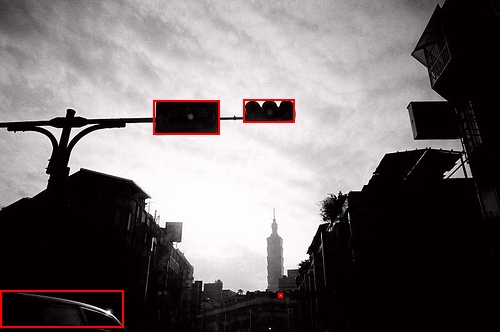

In [13]:
from PIL import ImageDraw

# Select a sample from the train dataset
sample_idx = 60  # Change this index to visualize different samples
sample = train_ds[sample_idx]

# Extract image and bounding boxes
image = sample['image']
bboxes = sample['objects']['bbox']
labels = sample['objects']['category']

# Convert the image to a PIL image
img = image
draw = ImageDraw.Draw(img)

# Draw the bounding boxes
for bbox in bboxes:
    x, y, x2, y2 = bbox
    # x2, y2 = x + w, y + h
    draw.rectangle([x, y, x2, y2], outline="red", width=2)

# Display the image with bounding boxes
img.show()

In [30]:
[i for i, val in enumerate(train_ds.features['objects'].feature['category'].names) if val == 'dog']

[16]

In [6]:
from collections import defaultdict

category_to_count = defaultdict(int)

for sample in filtered_train_ds:
    if len(sample['objects']['category']) == 0:
        print(sample)
    for obj in sample["objects"]["category"]:
        category_to_count[obj] += 1
category_to_count

defaultdict(int, {1: 4893})

In [7]:
import torch.optim as optim

output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

layer_size_map = {
    'conv3': (75, 75),
    'conv4': (37, 37),
    'conv5': (18, 18)
}

C = 256
pooled_height, pooled_width = 7, 7
anchor_box_ratios=[0.25, 0.5, 1, 2]
anchor_box_scales=[8, 16, 32]
num_anchors = len(anchor_box_ratios) * len(anchor_box_scales)
num_classes = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ckpt = torch.load("/home/ubuntu/rishabh/faster-rcnn/src/checkpoints/model_epoch_24.pth")

backbone = Backbone(output_layer_map).to(device)
# backbone.load_state_dict(ckpt['backbone_state_dict'])
fpn = FPN().to(device)
# fpn.load_state_dict(ckpt['fpn_state_dict'])
rpn = RPN(num_anchors=num_anchors).to(device)
# rpn.load_state_dict(ckpt['rpn_state_dict'])
head = DetectionHead(in_channels=C, pooled_height=pooled_height, pooled_width=pooled_width, num_classes=num_classes).to(device)
# head.load_state_dict(ckpt['head_state_dict'])

# backbone.eval()
# fpn.eval()
# rpn.eval()
# head.eval()

conv3 16
conv4 23
conv5 30


In [8]:
img_shape = (600, 600)
anchors = generate_anchors(ratios=anchor_box_ratios, scales=anchor_box_scales)

layer_to_shifted_anchors = dict()
for k in layer_size_map.keys():
    layer_h, layer_w = layer_size_map[k]
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), layer_h, layer_w, img_shape[0] // layer_h)).to(device).float()

print('Shifted Areas' + ('=' * 10))
for k, v in layer_to_shifted_anchors.items():
    areas = (v[:, 2] - v[:, 0] + 1) * (v[:, 3] - v[:, 1] + 1)
    average_area = areas.mean()
    min_area = areas.min()
    max_area = areas.max()
    print(f"{k}: Average Area: {average_area:.2f}, Min Area: {min_area:.2f}, Max Area: {max_area:.2f}")
print('Shifted Areas' + ('=' * 10))

print(anchors.size, layer_to_shifted_anchors['conv3'].size(), layer_to_shifted_anchors['conv4'].size(), layer_to_shifted_anchors['conv5'].size())



Shifted Areas==========
conv3: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
conv4: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
conv5: Average Area: 115360.00, Min Area: 15488.00, Max Area: 282624.00
Shifted Areas==========
48 torch.Size([67500, 4]) torch.Size([16428, 4]) torch.Size([3888, 4])


In [9]:
train_dataset = DetectionDataset(filtered_train_ds, transform_pipeline, preprocess)
val_dataset = DetectionDataset(filtered_val_ds, transform_pipeline, preprocess)

In [11]:
from tqdm import tqdm
import logging
from tqdm import tqdm
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_filename = f"train_metrics_{timestamp}.log"
train_log_filename = "train_metrics.log"
# val_log_filename = f"val_metrics_{timestamp}.log"
val_log_filename = "val_metrics.log"
log_dir = 'logs'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(
    filename=os.path.join(log_dir, train_log_filename),  # Log file name
    filemode='w',                  # Append mode; use 'w' to overwrite each time
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

train_logger = logging.getLogger("train")
val_logger = logging.getLogger("validation")
val_logger.setLevel(logging.INFO)
if val_logger.hasHandlers():
    val_logger.handlers.clear()
val_file_handler = logging.FileHandler(os.path.join(log_dir, val_log_filename), mode="w")
val_file_handler.setLevel(logging.INFO)
val_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
val_file_handler.setFormatter(val_formatter)
val_logger.addHandler(val_file_handler)
val_logger.propagate = False  # Prevent propagation to root logger

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=16, shuffle=False)
validation_loop_coco(val_dataloader, backbone, fpn, rpn, head, device,
                    layer_to_shifted_anchors, img_shape, num_classes, pooled_height, pooled_width, val_logger)

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([87816, 4]) torch.Size([2]) 2 126 torch.Size([87056]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([690]) 32 96 torch.Size([49339]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([340]) 32 96 torch.Size([59446]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2900]) 32 96 torch.Size([49643]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([484]) 32 96 torch.Size([53541]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([288]) 32 96 torch.Size([66473]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4750]) 32 96 torch.Size([51708]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([89]) 32 96 torch.Size([73146]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Size([87816]) torch.Size([3, 4])
torch.Size([87816, 4]) torch.Size([2201]) 32 96 torch.Size([47060]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([53]) 32 96 torch.Size([74353]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([114]) 32 96 torch.Size

Validation:  10%|█         | 1/10 [00:03<00:27,  3.09s/it]

torch.Size([87816, 4]) torch.Size([286]) 32 96 torch.Size([56171]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([136]) 32 96 torch.Size([64455]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Size([87811]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([206]) 32 96 torch.Size([60359]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([14]) 14 114 torch.Size([83477]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([87]) 32 96 torch.Size([69213]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1542]) 32 96 torch.Size([35013]) torch.Size([3, 4])
torch.Size([87816, 4]) torch.Size([3187]) 32 96 torch.Size([45800]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([12]) 12 116 torch.Size([85721]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([809]) 32 96 torch.Size([41063]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([471]) 32 96 torch.Size([51704]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([967]) 32 96 torch.Si

Validation:  20%|██        | 2/10 [00:05<00:22,  2.76s/it]

torch.Size([87816, 4]) torch.Size([2906]) 32 96 torch.Size([50009]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5067]) 32 96 torch.Size([42256]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([98]) 32 96 torch.Size([74785]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4426]) 32 96 torch.Size([44901]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([31]) 31 97 torch.Size([83856]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([44]) 32 96 torch.Size([82000]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([5778]) 32 96 torch.Size([48587]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2721]) 32 96 torch.Size([41551]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([43]) 32 96 torch.Size([77210]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([3]) 3 125 torch.Size([86494]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([51]) 32 96 torch.Size([80757]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5347]) 32 96 torch.Si

Validation:  30%|███       | 3/10 [00:08<00:18,  2.71s/it]

torch.Size([87816, 4]) torch.Size([1809]) 32 96 torch.Size([49745]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([201]) 32 96 torch.Size([64441]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([248]) 32 96 torch.Size([64611]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([51]) 32 96 torch.Size([77778]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([135]) 32 96 torch.Size([79696]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([17]) 17 111 torch.Size([81871]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4146]) 32 96 torch.Size([43562]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([3]) 3 125 torch.Size([86062]) torch.Size([3, 4])
torch.Size([87816, 4]) torch.Size([4168]) 32 96 torch.Size([48896]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6400]) 32 96 torch.Size([42278]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([148]) 32 96 torch.Size([67102]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([592]) 32 96 torch.

Validation:  40%|████      | 4/10 [00:10<00:15,  2.66s/it]

torch.Size([87816, 4]) torch.Size([2500]) 32 96 torch.Size([52707]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2442]) 32 96 torch.Size([40054]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([3]) 3 125 torch.Size([85435]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1214]) 32 96 torch.Size([59054]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([3381]) 32 96 torch.Size([52296]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([5256]) 32 96 torch.Size([44120]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1937]) 32 96 torch.Size([44094]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([3137]) 32 96 torch.Size([28087]) torch.Size([4, 4])
torch.Size([87816, 4]) torch.Size([56]) 32 96 torch.Size([77065]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([900]) 32 96 torch.Size([41636]) torch.Size([4, 4])
torch.Size([87816, 4]) torch.Size([28]) 28 100 torch.Size([80196]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([27]) 27 101 tor

Validation:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

torch.Size([87816, 4]) torch.Size([2843]) 32 96 torch.Size([36711]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([328]) 32 96 torch.Size([55395]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4949]) 32 96 torch.Size([49735]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([53]) 32 96 torch.Size([81570]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4310]) 32 96 torch.Size([47303]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([477]) 32 96 torch.Size([58397]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([882]) 32 96 torch.Size([50970]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6807]) 32 96 torch.Size([43376]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5423]) 32 96 torch.Size([36219]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([3877]) 32 96 torch.Size([43434]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Size([87068]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([11]) 11 117 torc

Validation:  60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

torch.Size([87816, 4]) torch.Size([5895]) 32 96 torch.Size([41018]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([386]) 32 96 torch.Size([49802]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6629]) 32 96 torch.Size([44799]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([26]) 26 102 torch.Size([83839]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([619]) 32 96 torch.Size([65159]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5816]) 32 96 torch.Size([47842]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([232]) 32 96 torch.Size([58834]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2915]) 32 96 torch.Size([49432]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([194]) 32 96 torch.Size([71194]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([23]) 23 105 torch.Size([79581]) torch.Size([4, 4])
torch.Size([87816, 4]) torch.Size([5258]) 32 96 torch.Size([49561]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2513]) 32 96 t

Validation:  70%|███████   | 7/10 [00:18<00:07,  2.66s/it]

torch.Size([87816, 4]) torch.Size([6678]) 32 96 torch.Size([46430]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2281]) 32 96 torch.Size([46707]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([207]) 32 96 torch.Size([67153]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([446]) 32 96 torch.Size([50216]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([381]) 32 96 torch.Size([64380]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Size([87236]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2051]) 32 96 torch.Size([56098]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([216]) 32 96 torch.Size([59803]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5076]) 32 96 torch.Size([51372]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5338]) 32 96 torch.Size([45953]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1]) 1 127 torch.Size([86885]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Si

Validation:  80%|████████  | 8/10 [00:21<00:05,  2.67s/it]

torch.Size([87816, 4]) torch.Size([1282]) 32 96 torch.Size([60328]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([4192]) 32 96 torch.Size([46922]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([966]) 32 96 torch.Size([52796]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6]) 6 122 torch.Size([86111]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([46]) 32 96 torch.Size([81637]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1402]) 32 96 torch.Size([64096]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6516]) 32 96 torch.Size([44910]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([27]) 27 101 torch.Size([78741]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([6236]) 32 96 torch.Size([44639]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([437]) 32 96 torch.Size([55984]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([1493]) 32 96 torch.Size([51701]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2916]) 32 96 tor

Validation:  90%|█████████ | 9/10 [00:24<00:02,  2.67s/it]

torch.Size([87816, 4]) torch.Size([304]) 32 96 torch.Size([53979]) torch.Size([3, 4])
torch.Size([87816, 4]) torch.Size([5681]) 32 96 torch.Size([47062]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1443]) 32 96 torch.Size([56187]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2635]) 32 96 torch.Size([43017]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1780]) 32 96 torch.Size([54691]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([0]) 0 128 torch.Size([87754]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([5288]) 32 96 torch.Size([35415]) torch.Size([2, 4])
torch.Size([87816, 4]) torch.Size([5641]) 32 96 torch.Size([44838]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([1723]) 32 96 torch.Size([52604]) torch.Size([1, 4])
torch.Size([87816, 4]) torch.Size([2400]) 32 96 torch.Size([51033]) torch.Size([1, 4])
inside nms
tensor([[  0.0000,   0.0000,  28.3382, 400.0031, 299.6421],
        [  0.0000,   0.0000,   0.0000, 466.8488, 249.8764],
   

Validation: 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...


index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=mediu

{'avg_loss': 1.7881868004798889,
 'AP_small': np.float64(0.0),
 'AP_medium': np.float64(0.0),
 'AP_large': np.float64(0.006924267206261412)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


<class 'torch.Tensor'> <class 'dict'>
inside nms
tensor([[  0.0000,   0.0000,   0.0000, 324.3461, 364.3239],
        [  0.0000,   0.0000,   0.0000, 315.2617, 381.9062],
        [  0.0000,   0.0000,   0.0000, 243.1901, 475.6581],
        [  0.0000,   0.0000,   0.0000, 331.6913, 377.7188],
        [  0.0000,   0.0000,   0.0000, 244.6732, 511.3307]], device='cuda:0') tensor([0.1286, 0.2315, 0.1072, 0.2465, 0.1307], device='cuda:0')
torch.Size([3, 2]) torch.Size([3, 4]) torch.Size([3, 2])
torch.Size([3, 4])
max rpn score: 0.9999712705612183
max score: 0.9995012283325195
torch.Size([3, 4])


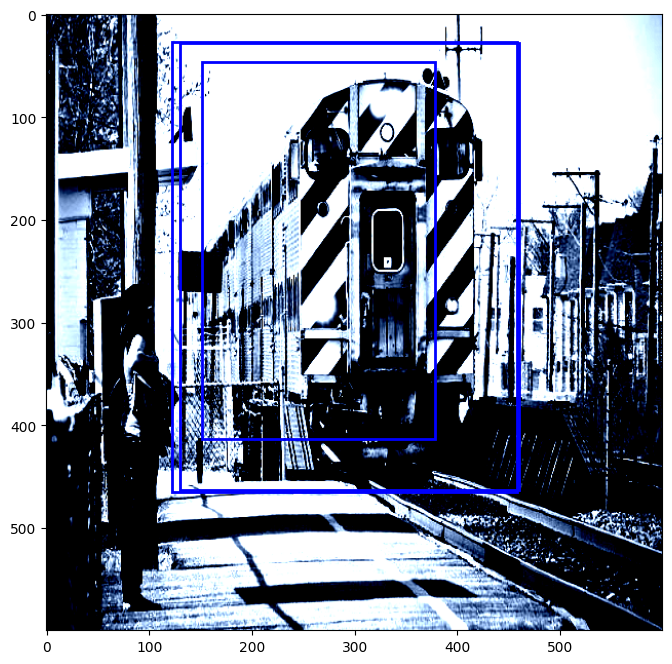

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

idx = 105
with torch.no_grad():
    images, targets = train_dataset[idx]
    images = images.unsqueeze(0)
    print(type(images), type(targets))
    images = images.to(device)
    targets = add_batch_idx_to_targets([targets])
    gt = torch.cat([t['boxes_with_label'] for t in targets], dim=0).to(device)
    rpn_gt = gt.clone()
    # Convert labels to binary for the RPN (foreground vs background)
    rpn_gt[:, 5] = 1

    # Forward pass: Backbone -> FPN.
    features = backbone(images)
    fpn_features = fpn(features)

    # Forward pass through the RPN at each FPN level.
    rpn_out = {}
    for k, feature_map in fpn_features.items():
        rpn_out[k] = rpn(feature_map)
    sorted_rpn_keys = sorted(rpn_out.keys())

    # Aggregate RPN outputs.
    all_rpn_deltas = torch.cat(
        [collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0
    )
    rois = torch.cat(
        [generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape)
            for k in sorted_rpn_keys], dim=0
    )
    scores = torch.cat(
        [get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0
    )

    # Process proposals for the detection head.
    unique_batches = rois[:, 0].unique()
    all_proposals = []
    all_scores = []
    for batch_idx in unique_batches:
        batch_mask = rois[:, 0] == batch_idx
        batch_rois = rois[batch_mask]
        batch_scores = scores[batch_mask]

        # Apply Non-Maximum Suppression (NMS) per batch.
        keep = nms(batch_rois, batch_scores[:, 1])
        batch_rois = batch_rois[keep]
        batch_scores = batch_scores[keep]

        # Sort proposals by score.
        _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
        sorted_proposals = batch_rois[sorted_indices]
        sorted_scores = batch_scores[sorted_indices]

        K = 3  # Adjust K based on your requirements.
        topk_proposals = sorted_proposals[:K]
        topk_scores = sorted_scores[:K]

        all_proposals.append(topk_proposals)
        all_scores.append(topk_scores)

    all_proposals = torch.cat(all_proposals, dim=0)
    all_scores = torch.cat(all_scores, dim=0)

    # ROI Align: pool features corresponding to the proposals.
    levels = sorted([int(x[-1]) for x in rpn_out.keys()])
    aligned_proposals = perform_roi_align(
        levels, all_proposals, fpn_features,
        pooled_height, pooled_width, img_shape
    )

    # Forward pass through the detection head.
    cls_scores, bbox_deltas = head(aligned_proposals)

    print(cls_scores.size(), bbox_deltas.size(), all_scores.size())

    # Decode the bounding boxes
    decoded_boxes = decode_boxes(all_proposals[:, 1:], bbox_deltas, img_shape)

    # Print the decoded boxes
    print(decoded_boxes.size())

    # Get the bounding boxes with a probability greater than 0.5
    cls_scores = torch.softmax(cls_scores, dim=1)
    all_scores = torch.softmax(all_scores, dim=1)
    max_score = cls_scores[:, 1].max()
    max_rpn_score = all_scores[:, 1].max()
    print(f'max rpn score: {max_rpn_score}')
    print(f'max score: {max_score}')
    high_prob_indices = torch.where(cls_scores[:, 1] > 0.1)[0]
    high_prob_boxes = decoded_boxes[high_prob_indices]
    print(high_prob_boxes.size())

    # Convert the image tensor to a NumPy array for plotting.
    # This assumes your tensor is in (batch, channels, height, width) format.
    img = images.squeeze(0).permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Draw the first set of boxes (in red, thin lines)
    # for box in decoded_boxes[:200]:
    #     x1, y1, x2, y2 = box.detach().cpu()
    #     width = x2 - x1
    #     height = y2 - y1
    #     rect = patches.Rectangle((x1, y1), width, height,
    #                             linewidth=2, edgecolor='blue', facecolor='none')
    #     ax.add_patch(rect)
    
    # for box in gt[:, 1:5]:
    #     x1, y1, x2, y2 = box.detach().cpu()
    #     width = x2 - x1
    #     height = y2 - y1
    #     rect = patches.Rectangle((x1, y1), width, height,
    #                             linewidth=2, edgecolor='blue', facecolor='none')
    #     ax.add_patch(rect)


    # Draw the bounding boxes with a probability greater than 0.5 (in blue, thick lines)
    for box in high_prob_boxes:
        x1, y1, x2, y2 = box.detach().cpu()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

Test Trained Models

In [4]:
import json

from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch
import datasets

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
tgt_categories = [16]

ds = datasets.load_dataset('detection-datasets/coco')
train_ds = ds['train']
val_ds = ds['val']

mapped_val_ds = val_ds.map(lambda sample: filter_bboxes_in_sample(sample, tgt_categories))
filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

In [14]:
gt = json.load(open('temp_gt.json', 'r'))
preds = json.load(open('temp_preds.json', 'r'))

gt.keys(), preds[0].keys()

(dict_keys(['images', 'annotations', 'categories']),
 dict_keys(['image_id', 'category_id', 'bbox', 'score']))

In [15]:
config = load_config('../config.yaml')
augmentation_transform_test = setup_augmentation_transform(config, mode='test')

In [16]:
all_image_ids = sorted([x['id'] for x in gt['images']])
predicted_image_ids = sorted(list(set([p['image_id'] for p in preds])))
non_predicted_image_ids = sorted(list(set(all_image_ids) - set(predicted_image_ids)))

len(all_image_ids), len(predicted_image_ids), len(non_predicted_image_ids)

(152, 117, 35)

/tmp/ipykernel_4113/3416266920.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([predicted_areas, non_predicted_areas], labels=['Predicted Areas', 'Non-Predicted Areas'])


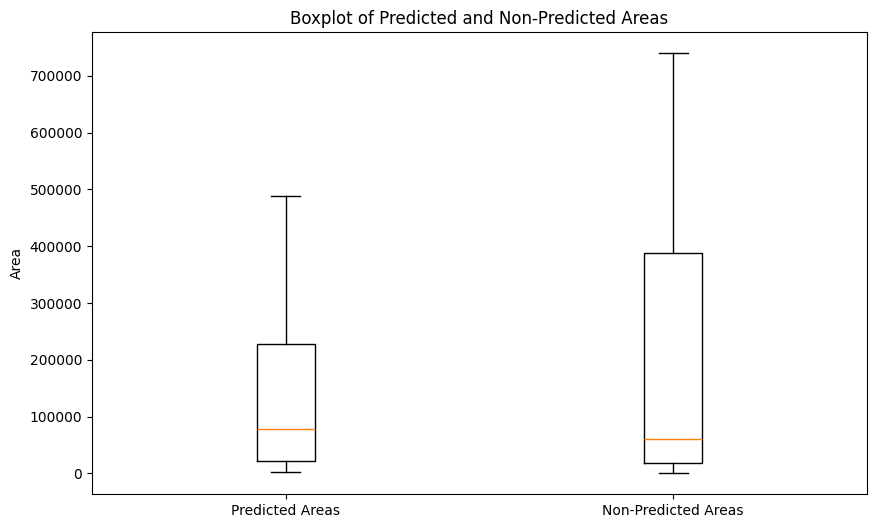

In [69]:
non_predicted_areas = [ann['bbox'][2]* ann['bbox'][3] for ann in gt['annotations'] if ann['image_id'] in non_predicted_image_ids]
predicted_areas = [p['bbox'][2] * p['bbox'][3] for p in preds]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([predicted_areas, non_predicted_areas], labels=['Predicted Areas', 'Non-Predicted Areas'])
plt.ylabel('Area')
plt.title('Boxplot of Predicted and Non-Predicted Areas')
plt.show()

[{'id': 90, 'image_id': 71, 'category_id': 1, 'bbox': [190.8326416015625, 113.43189239501953, 471.6544189453125, 813.001335144043], 'area': 383455.67232912686, 'iscrowd': 0}] [{'image_id': 71, 'category_id': 1, 'bbox': [203.13046264648438, 182.13223266601562, 429.2237854003906, 683.5875244140625], 'score': 0.8078529238700867}, {'image_id': 71, 'category_id': 1, 'bbox': [211.51504516601562, 155.881103515625, 449.2531433105469, 618.748291015625], 'score': 0.8656893968582153}, {'image_id': 71, 'category_id': 1, 'bbox': [204.11978149414062, 198.72314453125, 418.1427917480469, 650.2301025390625], 'score': 0.7331287860870361}, {'image_id': 71, 'category_id': 1, 'bbox': [191.27804565429688, 203.88992309570312, 416.5021057128906, 696.4244384765625], 'score': 0.7512092590332031}, {'image_id': 71, 'category_id': 1, 'bbox': [214.8236846923828, 161.7344970703125, 420.29449462890625, 660.2684936523438], 'score': 0.8613821268081665}, {'image_id': 71, 'category_id': 1, 'bbox': [186.6710968017578, 203

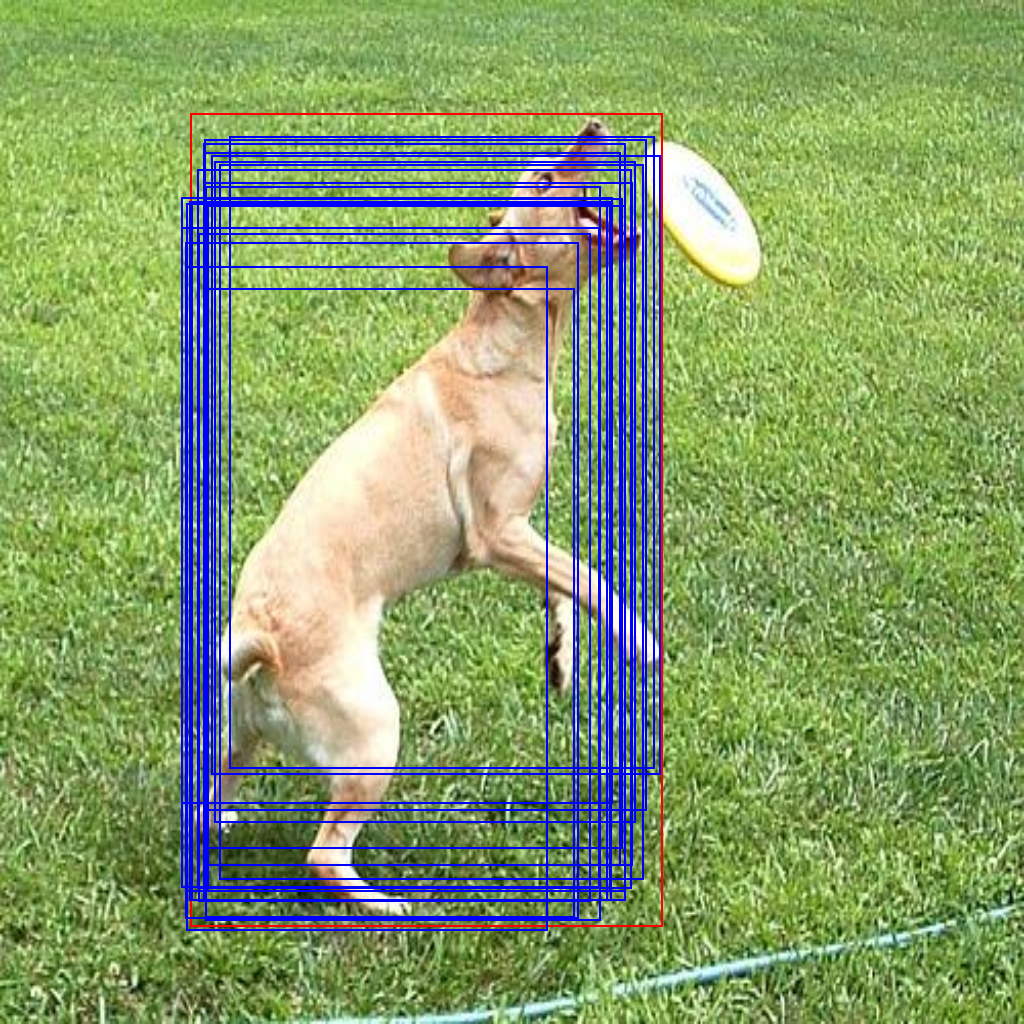

In [67]:
import base64
import json
from io import BytesIO
from PIL import Image, ImageDraw
import numpy as np

image_id = predicted_image_ids[55]

gt_ann = [ann for ann in gt['annotations'] if ann['image_id'] == image_id]
pred_ann = [ann for ann in preds if ann['image_id'] == image_id]

img_str = [g for g in gt['images'] if g['id'] == image_id][0]['image']

byte_data = base64.b64decode(img_str)

# 4. Wrap those bytes in a BytesIO buffer and open as a PIL image.
buffer = BytesIO(byte_data)
img = Image.open(buffer)

print(gt_ann, pred_ann)

# img.show()

img = augmentation_transform_test(image=np.array(filtered_val_ds[image_id-1]['image'].convert('RGB')), bbox=[], category=[])['image']
img = Image.fromarray(img).convert("RGB")

draw = ImageDraw.Draw(img)

for ann in gt_ann:
    x, y, w, h = ann['bbox']
    draw.rectangle([x, y, x+w, y+h], outline="red", width=2)

for ann in pred_ann:
    x, y, w, h = ann['bbox']
    draw.rectangle([x, y, x+w, y+h], outline="blue", width=2)

img.show()

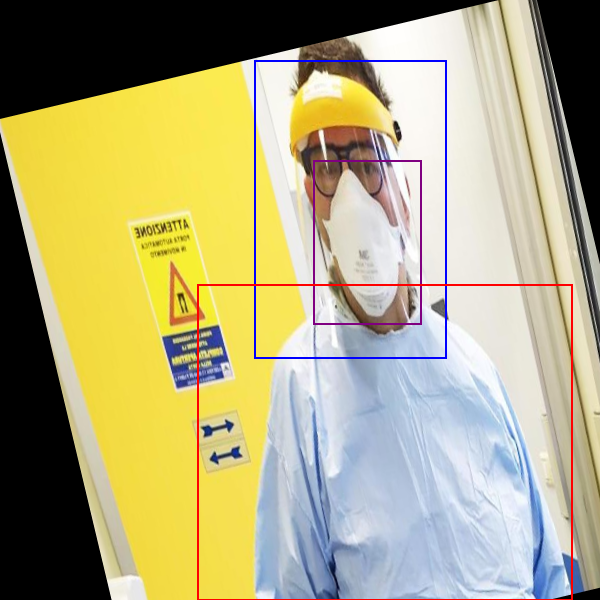

In [48]:
from PIL import ImageDraw

sample = dataset[39][1]
image = sample['augmented_image'].copy()
draw = ImageDraw.Draw(image)

boxes = sample['boxes']
labels = sample['labels']

# Define some colors. You can customize these.
colors = ["red", "blue", "green", "yellow", "purple", "orange"]

for i in range(boxes.size(0)):
    # Convert the box to a list of numbers.
    x, y, w, h = boxes[i].tolist()
    # Compute bottom-right coordinates.
    x2, y2 = x + w, y + h

    # Choose a color based on label (or you can define a mapping from label to color).
    label = int(labels[i].item())
    color = colors[label % len(colors)]

    # Draw the rectangle.
    draw.rectangle([x, y, x2, y2], outline=color, width=2)

image